In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import mne.filter
from mne.time_frequency import psd_array_multitaper
%matplotlib inline

In [2]:
def gen_data(n_ch=5, n_ts=100, ampl=10):
    A = np.cumsum(np.random.rand(n_ch, n_ts) * ampl - ampl / 2.0, axis=1)
    A_ref = np.cumsum(np.random.rand(n_ch, n_ts) * ampl - ampl / 2.0, axis=1)
    B = np.cumsum(np.random.rand(n_ch, n_ts) * ampl - ampl / 2.0, axis=1)
    B_ref = np.cumsum(np.random.rand(n_ch, n_ts) * ampl - ampl / 2.0, axis=1)
    
    return A, A_ref, B, B_ref

In [3]:
A, A_ref, B, B_ref = gen_data()

In [4]:
A.shape

(5, 100)

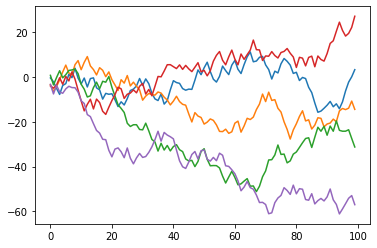

In [5]:
_ = plt.plot(A.T)

In [36]:
import bisect

In [78]:
def rolling_window_psd(signal, window=10, stride=1, sampling_freq=250):
    out = {'delta': [],
           'theta': [],
           'alpha': [],
           'beta': []}
    range_lim = {'delta': (0.5, 3),
                 'theta': (4, 7),
                 'alpha': (7, 15),
                 'beta': (15, 30)}
    
    n_sources, n_ts = signal.shape
    for w_start in range(0, n_ts - window, stride):
        psds, freqs = psd_array_multitaper(signal[:, w_start:w_start + window], 
                                           sampling_freq, verbose=False)
        total_power = psds.sum(axis=1)
#         print(w_start, total_power)
        
#         print('freqs', freqs)
        for band, [freq_from, freq_to] in range_lim.items():
#             idx_from = np.where(freqs > freq_from)[0][0]
#             idx_to = np.where(freqs > freq_to)[0][0]
            idx_from = bisect.bisect_left(freqs, freq_from)
            idx_to = bisect.bisect_left(freqs, freq_to)
#             print(freq_from, idx_from, freq_to, idx_to)
            band_power = psds[:, idx_from:idx_to].sum(axis=1) / total_power
#             print(band_power)
            out[band].append(band_power)
    
    for band, data in out.items():
#         print(out[band])
        out[band] = np.stack(out[band], axis=0).T
    return out

In [104]:
A_bandpass     = rolling_window_psd(A, window=30, stride=30, sampling_freq=250)
A_ref_bandpass = rolling_window_psd(A_ref, window=30, stride=30, sampling_freq=250)
B_bandpass     = rolling_window_psd(B, window=30, stride=30, sampling_freq=250)
B_ref_bandpass = rolling_window_psd(B_ref, window=30, stride=30, sampling_freq=250)

In [105]:
for k, v in A_bandpass.items(): print(v.shape)

(5, 3)
(5, 3)
(5, 3)
(5, 3)


In [106]:
A_bandpass

{'delta': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), 'theta': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), 'alpha': array([[0.21908837, 0.21316243, 0.26485788],
        [0.22078655, 0.25378004, 0.23141182],
        [0.27339937, 0.2103039 , 0.26021551],
        [0.22739598, 0.229561  , 0.12855668],
        [0.26564384, 0.24071269, 0.23136872]]), 'beta': array([[0.36278461, 0.36922027, 0.36856314],
        [0.33511687, 0.4329552 , 0.32151073],
        [0.38856237, 0.40754572, 0.41867991],
        [0.35533527, 0.33403544, 0.22531596],
        [0.45145235, 0.32911475, 0.26361625]])}

In [112]:
from scipy.stats import f_oneway

print('ANOVA testing A ~ A_ref')

for band in A_bandpass.keys():
    # ANOVA for A ~ A_ref comparison
    F, p = f_oneway(A_bandpass[band].T, A_ref_bandpass[band].T)
    print(f'{band} A ~ A_ref:', p)

print()
print('ANOVA testing B ~ B_ref')

for band in A_bandpass.keys():
    # ANOVA for A ~ A_ref comparison
    F, p = f_oneway(B_bandpass[band].T, B_ref_bandpass[band].T)
    print(f'{band} B ~ B_ref:', p)

print()
print('ANOVA testing [A B] ~ [A_ref B_ref]')    

for band in A_bandpass.keys():
    # ANOVA for [A B] ~ [A_ref B_ref] comparison
    # (heteroskedasticity assumption might be wrong here; do we need a test for heterskedasticity?)
    comb = np.concatenate([A_bandpass[band], B_bandpass[band]], axis=1)
    comb_ref = np.concatenate([A_ref_bandpass[band], B_ref_bandpass[band]], axis=1)
    F, p = f_oneway(comb.T, comb_ref.T)
    
    print(f'{band} [A B] ~ [A_ref B_ref]:', p)

ANOVA testing A ~ A_ref
delta A ~ A_ref: [nan nan nan nan nan]
theta A ~ A_ref: [nan nan nan nan nan]
alpha A ~ A_ref: [0.36578702 0.34425864 0.6746448  0.25102146 0.97158197]
beta A ~ A_ref: [0.10140331 0.86241222 0.26305068 0.11510618 0.64931851]

ANOVA testing B ~ B_ref
delta B ~ B_ref: [nan nan nan nan nan]
theta B ~ B_ref: [nan nan nan nan nan]
alpha B ~ B_ref: [0.1749146  0.94677614 0.17615821 0.20831373 0.09184272]
beta B ~ B_ref: [0.01712931 0.74980456 0.30402171 0.38210747 0.14946533]

ANOVA testing [A B] ~ [A_ref B_ref]
delta [A B] ~ [A_ref B_ref]: [nan nan nan nan nan]
theta [A B] ~ [A_ref B_ref]: [nan nan nan nan nan]
alpha [A B] ~ [A_ref B_ref]: [0.12516996 0.82663972 0.3289639  0.40996016 0.24404744]
beta [A B] ~ [A_ref B_ref]: [0.00289805 0.88487439 0.69279576 0.23609557 0.15567273]


In [114]:
from scipy.stats import ttest_ind

print('T-test (2-sided for mean equality) testing A ~ A_ref')

for band in A_bandpass.keys():
    # T-test for A ~ A_ref comparison
    F, p = ttest_ind(A_bandpass[band].T, A_ref_bandpass[band].T)
    print(f'{band} A ~ A_ref:', p)

print()
print('T-test (2-sided for mean equality) testing B ~ B_ref')

for band in A_bandpass.keys():
    # T-test for A ~ A_ref comparison
    F, p = ttest_ind(B_bandpass[band].T, B_ref_bandpass[band].T)
    print(f'{band} B ~ B_ref:', p)

print()
print('T-test (2-sided for mean equality) testing [A B] ~ [A_ref B_ref]')    

for band in A_bandpass.keys():
    # T-test for [A B] ~ [A_ref B_ref] comparison
    # (heteroskedasticity assumption might be wrong here; do we need a test for heteroskedasticity?)
    comb = np.concatenate([A_bandpass[band], B_bandpass[band]], axis=1)
    comb_ref = np.concatenate([A_ref_bandpass[band], B_ref_bandpass[band]], axis=1)
    F, p = ttest_ind(comb.T, comb_ref.T)
    
    print(f'{band} [A B] ~ [A_ref B_ref]:', p)

T-test (2-sided for mean equality) testing A ~ A_ref
delta A ~ A_ref: [nan nan nan nan nan]
theta A ~ A_ref: [nan nan nan nan nan]
alpha A ~ A_ref: [0.36578702 0.34425864 0.6746448  0.25102146 0.97158197]
beta A ~ A_ref: [0.10140331 0.86241222 0.26305068 0.11510618 0.64931851]

T-test (2-sided for mean equality) testing B ~ B_ref
delta B ~ B_ref: [nan nan nan nan nan]
theta B ~ B_ref: [nan nan nan nan nan]
alpha B ~ B_ref: [0.1749146  0.94677614 0.17615821 0.20831373 0.09184272]
beta B ~ B_ref: [0.01712931 0.74980456 0.30402171 0.38210747 0.14946533]

T-test (2-sided for mean equality) testing [A B] ~ [A_ref B_ref]
delta [A B] ~ [A_ref B_ref]: [nan nan nan nan nan]
theta [A B] ~ [A_ref B_ref]: [nan nan nan nan nan]
alpha [A B] ~ [A_ref B_ref]: [0.12516996 0.82663972 0.3289639  0.40996016 0.24404744]
beta [A B] ~ [A_ref B_ref]: [0.00289805 0.88487439 0.69279576 0.23609557 0.15567273]


#### **TODO: multiple comparisons**

#### Auxiliary functions

In [81]:
def bandpass_signal(signal, sampling_rate=250, verbose=False):
    delta = mne.filter.filter_data(signal, sampling_rate, .5, 3, verbose=verbose)
    theta = mne.filter.filter_data(signal, sampling_rate, 3, 8, verbose=verbose)
    alpha = mne.filter.filter_data(signal, sampling_rate, 8, 12, verbose=verbose)
    beta  = mne.filter.filter_data(signal, sampling_rate, 12, 38, verbose=verbose)
    gamma = mne.filter.filter_data(signal, sampling_rate, 38, 42, verbose=verbose)
    return {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}

<ipython-input-81-2c44704e0129>:2: RuntimeWarning: filter_length (1651) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  delta = mne.filter.filter_data(signal, sampling_rate, .5, 3, verbose=verbose)
<ipython-input-81-2c44704e0129>:3: RuntimeWarning: filter_length (413) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  theta = mne.filter.filter_data(signal, sampling_rate, 3, 8, verbose=verbose)
<ipython-input-81-2c44704e0129>:4: RuntimeWarning: filter_length (413) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  alpha = mne.filter.filter_data(signal, sampling_rate, 8, 12, verbose=verbose)
<ipython-input-81-2c44704e0129>:5: RuntimeWarning: filter_length (275) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  beta  = mne.filter.filter_data(signal, sampling_rate, 12, 38, 

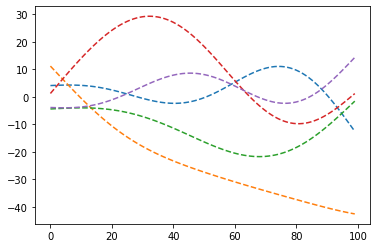

In [90]:
A_bp = bandpass_signal(A)
plt.plot(A_bp['delta'].T, '--')

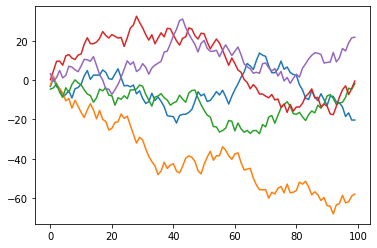

In [88]:
plt.plot(A.T)